<a href="https://colab.research.google.com/github/Najamzfr/ML-Zoomcamp-Project2/blob/main/Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stock Market Analysis and Portfolio Optimization Notebook

In [10]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from scipy.optimize import minimize

In [15]:
#Step 1: Create directory structure
def create_directories():
    directories = [
        "data/raw",
        "data/processed",
        "notebooks",
        "src",
        "models/saved_models",
        "models/model_analysis",
        "reports/figures",
        "tests",
    ]
    for directory in directories:
        os.makedirs(directory, exist_ok=True)

# Step 1: Create necessary directories
print("Creating directories...")
create_directories()
print("Created directories :)")

Creating directories...
Created directories :)


In [16]:
# Step 2: Download stock data
def download_stock_data(tickers, start_date, end_date):
    raw_data_path = "data/raw"
    for ticker in tickers:
        print(f"Downloading data for {ticker}...")
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        file_path = os.path.join(raw_data_path, f"{ticker}.csv")
        stock_data.to_csv(file_path)
        print(f"Saved {ticker} data to {file_path}")


print("Step 2: Downloading stock data...")
tickers = ["AAPL", "TSLA", "GOOGL"]  # Example stock symbols
start_date = "2018-01-01"
end_date = "2024-12-31"
download_stock_data(tickers, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Step 2: Downloading stock data...
Saved AAPL data to data/raw/AAPL.csv
Saved TSLA data to data/raw/TSLA.csv
Saved GOOGL data to data/raw/GOOGL.csv


In [17]:
df = pd.read_csv("data/raw/AAPL.csv")
df

,Price,Close,High,Low,Open,Volume
0,Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
1,Date,NaN,NaN,NaN,NaN,NaN
2,2018-01-02,40.52433776855469,40.53374981917436,39.818584737192324,40.03031280038836,102223600
3,2018-01-03,40.51728057861328,41.06306464661334,40.45376539025206,40.58785659977129,118071600
4,2018-01-04,40.70549011230469,40.80900115174529,40.48200232604679,40.590215802082874,89738400
...,...,...,...,...,...,...
1757,2024-12-23,255.27000427246094,255.64999389648438,253.4499969482422,254.77000427246094,40858800
1758,2024-12-24,258.20001220703125,258.2099914550781,255.2899932861328,255.49000549316406,23234700
1759,2024-12-26,259.0199890136719,260.1000061035156,257.6300048828125,258.19000244140625,27237100
1760,2024-12-27,255.58999633789062,258.70001220703125,253.05999755859375,257.8299865722656,42355300


In [19]:
# Step 3: Data Preprocessing
def preprocess_data():
    raw_data_path = "data/raw"
    processed_data_path = "data/processed"

    for file in os.listdir(raw_data_path):
        if file.endswith(".csv"):
            print(f"Processing {file}...")
            file_path = os.path.join(raw_data_path, file)
            data = pd.read_csv(file_path, header=2, parse_dates=["Date"], index_col="Date")
            data = data.rename(columns={'Unnamed: 1': 'Close',
                                        'Unnamed: 2': 'High',
                                        'Unnamed: 3': 'Low',
                                        'Unnamed: 4': 'Open',
                                        'Unnamed: 5': 'Volume'})

            # Retain only relevant columns
            data = data[["Close"]]

            # Remove NaN rows (if any)
            data = data.dropna()

            # Save the processed data
            processed_file_path = os.path.join(processed_data_path, file)
            data.to_csv(processed_file_path)
            print(f"Saved processed data to {processed_file_path}")

# Step 3: Preprocess downloaded data
print("Preprocessing data...")
preprocess_data()
print()
print("Step 3: Preprocessed data :)")

Preprocessing data...
Processing MSFT.csv...
Saved processed data to data/processed/MSFT.csv
Processing AMZN.csv...
Saved processed data to data/processed/AMZN.csv
Processing TSLA.csv...
Saved processed data to data/processed/TSLA.csv
Processing GOOGL.csv...
Saved processed data to data/processed/GOOGL.csv
Processing AAPL.csv...
Saved processed data to data/processed/AAPL.csv

Step 3: Preprocessed data :)


## Doing EDA on only 1 stock

In [23]:
df = pd.read_csv("data/processed/features_AAPL.csv")


,Date,Close,Lag_1,Lag_2,MA_5,MA_10
0,2018-01-16,41.448887,41.660606,41.234798,41.271501,41.028957
1,2018-01-17,42.133461,41.448887,41.660606,41.495930,41.189869
2,2018-01-18,42.171097,42.133461,41.448887,41.729770,41.355251
3,2018-01-19,41.982903,42.171097,42.133461,41.879391,41.482992
4,2018-01-22,41.639435,41.982903,42.171097,41.875156,41.530043
...,...,...,...,...,...,...
1746,2024-12-23,255.270004,254.490005,249.789993,252.216000,250.247002
1747,2024-12-24,258.200012,255.270004,254.490005,253.160004,251.290002
1748,2024-12-26,259.019989,258.200012,255.270004,255.354001,252.543001
1749,2024-12-27,255.589996,259.019989,258.200012,256.514001,253.306000


In [26]:
df.describe()

,Close,Lag_1,Lag_2,MA_5,MA_10
count,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000
mean,122.746837,122.626597,122.504179,122.502582,122.197506
std,59.188180,59.138881,59.085323,59.047301,58.880080
min,33.952530,33.952530,33.952530,35.456396,35.973602
25%,55.410900,55.044807,54.864325,55.104278,54.405077
50%,132.334976,132.216446,132.100830,132.225317,132.366022
75%,169.435478,169.415916,169.414856,170.052681,169.347111
max,259.019989,259.019989,259.019989,256.514001,253.712999


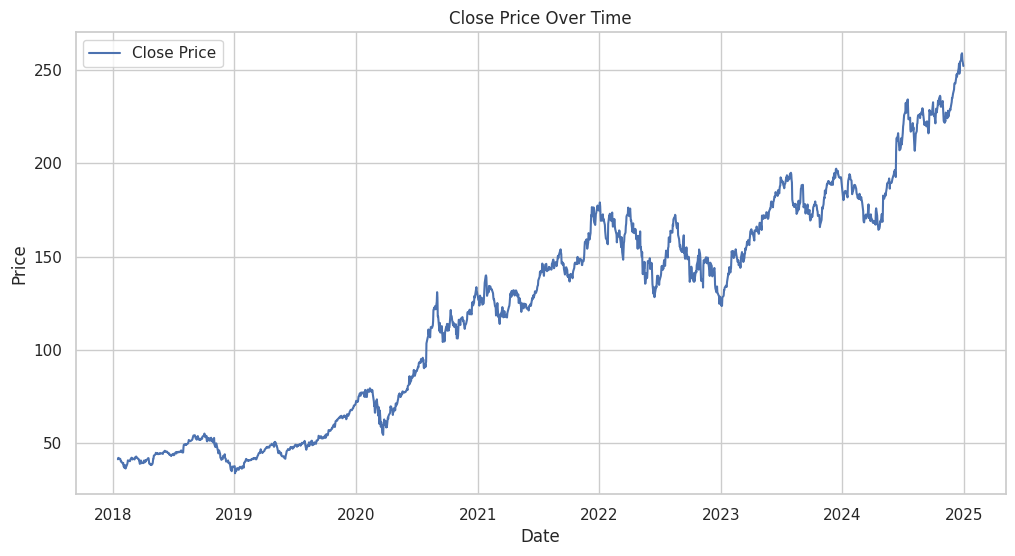

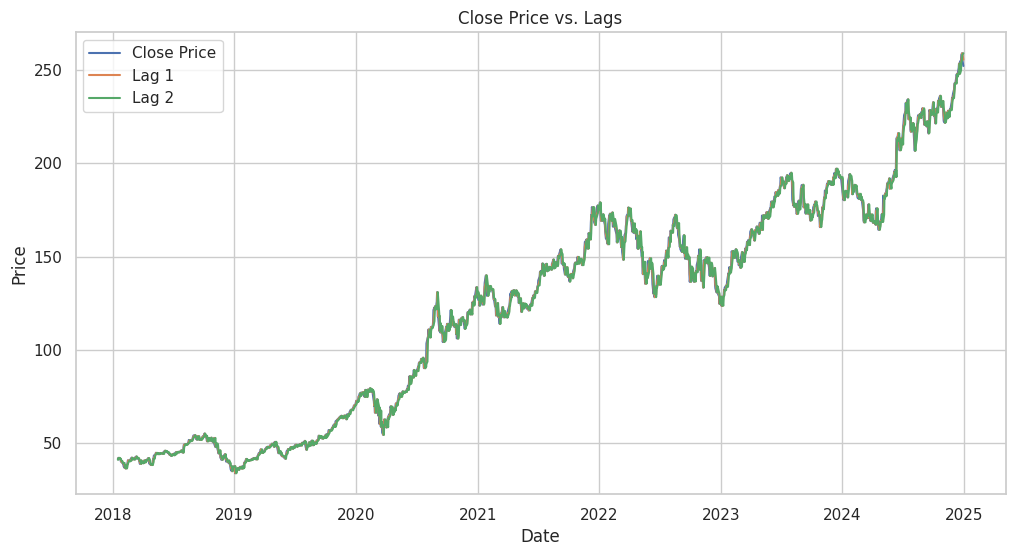

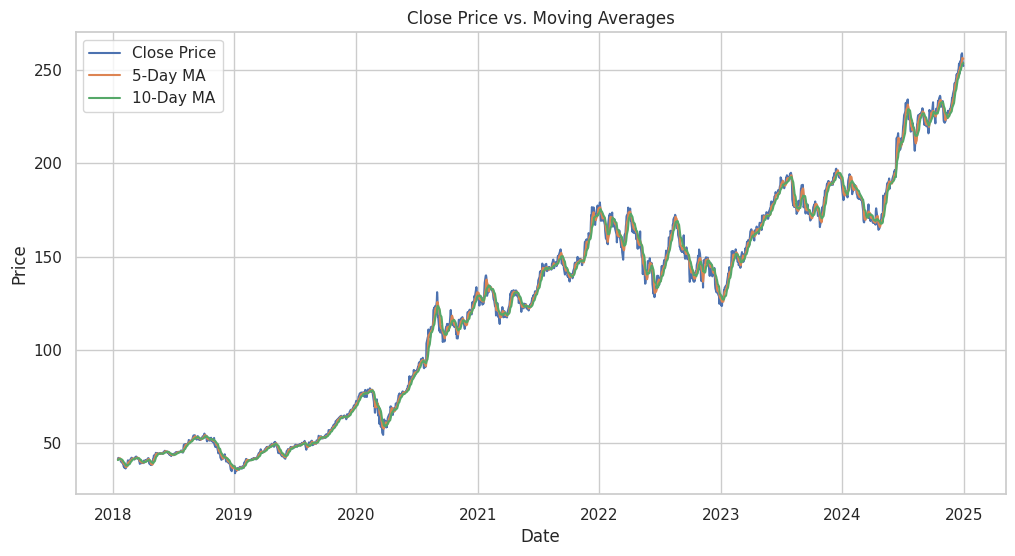

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df = df.set_index('Date')


# Create the first plot: Close price over time
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# Create the second plot: Close price, Lag_1, and Lag_2
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Lag_1'], label='Lag 1')
plt.plot(df['Lag_2'], label='Lag 2')
plt.title('Close Price vs. Lags')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# Create the third plot: Close price and moving averages (MA_5 and MA_10)
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA_5'], label='5-Day MA')
plt.plot(df['MA_10'], label='10-Day MA')
plt.title('Close Price vs. Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1200x800 with 0 Axes>

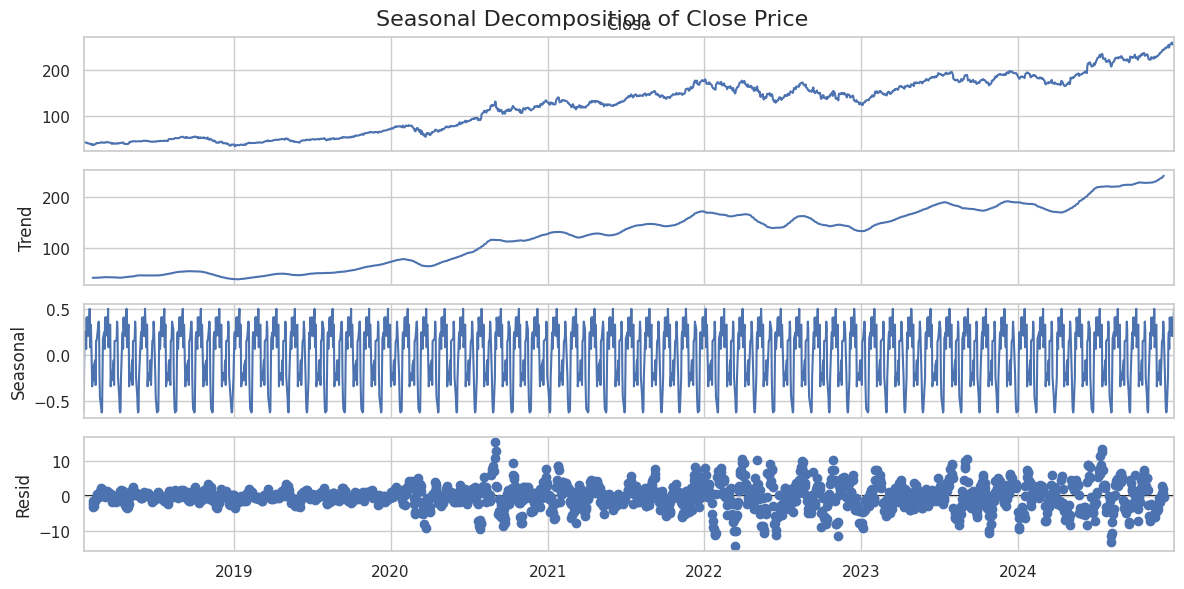

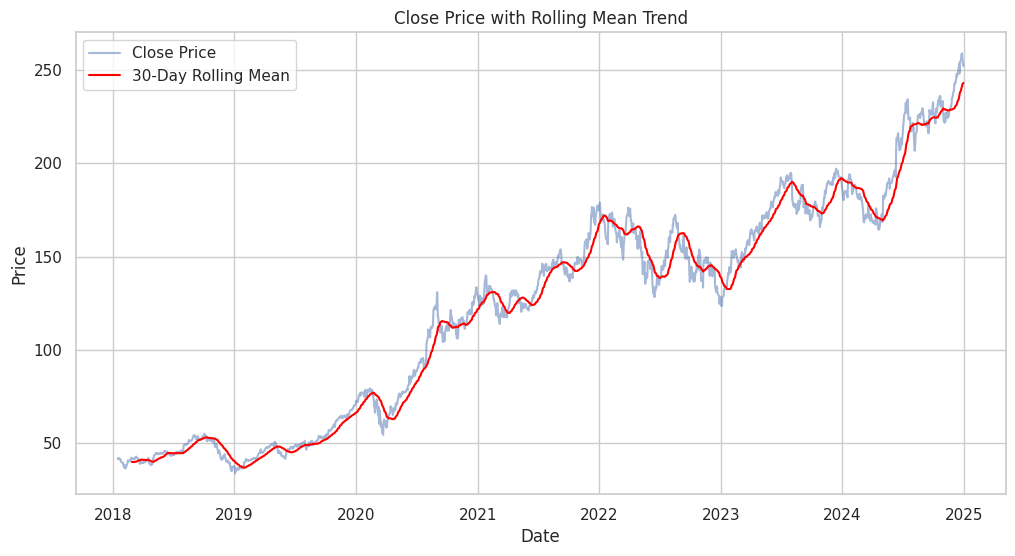

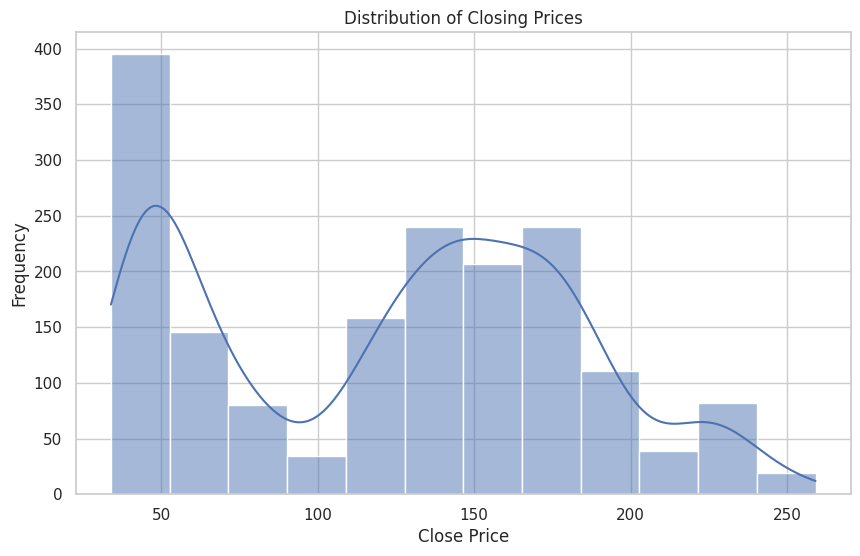

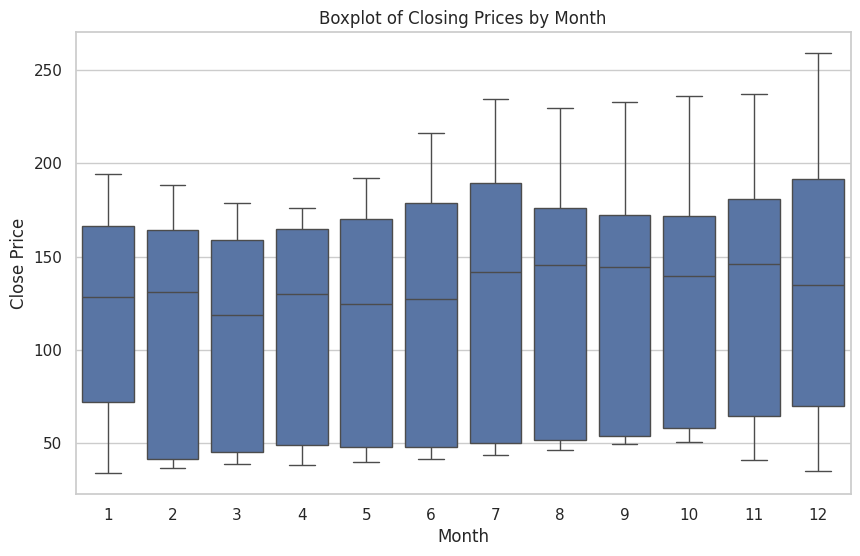

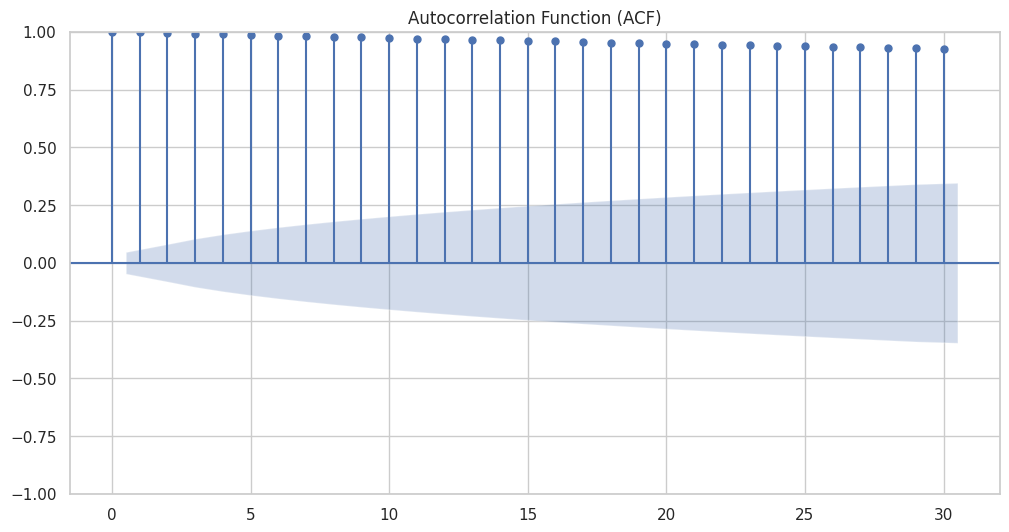

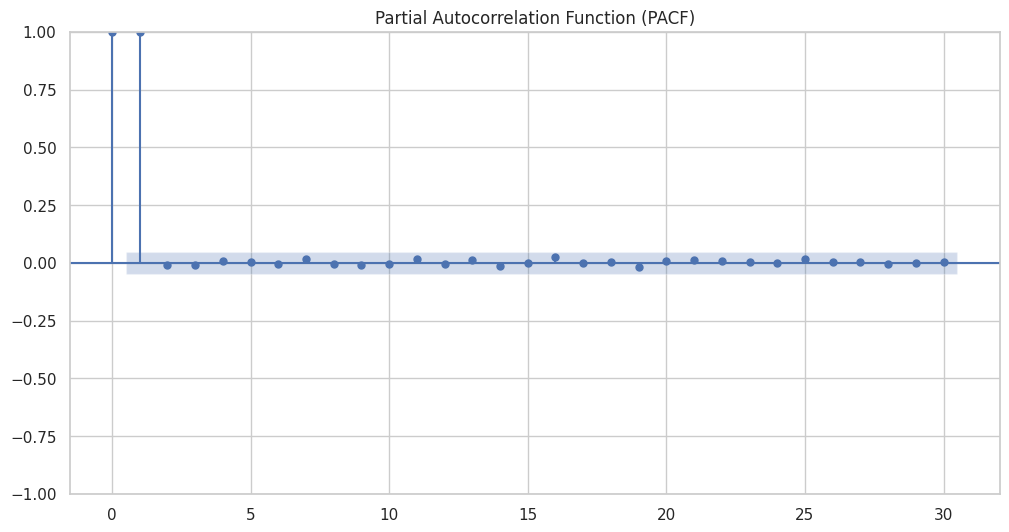

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'df' is your DataFrame with a datetime index and 'Close' price data

# Seasonal Decomposition
result = seasonal_decompose(df['Close'], model='additive', period=30) # Adjust period as needed

plt.figure(figsize=(12, 8))
result.plot()
plt.suptitle('Seasonal Decomposition of Close Price', fontsize=16)
plt.show()


# Trend Visualization with Rolling Mean
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['Close'].rolling(window=30).mean(), label='30-Day Rolling Mean', color='red') # Adjust window
plt.title('Close Price with Rolling Mean Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# Distribution of Closing Prices
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True)
plt.title('Distribution of Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()


# Boxplot of Closing Prices by Month
df['Month'] = df.index.month
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Close', data=df)
plt.title('Boxplot of Closing Prices by Month')
plt.xlabel('Month')
plt.ylabel('Close Price')
plt.show()

# Remove the temporary 'Month' column
df = df.drop('Month', axis=1)

# Autocorrelation Plot (ACF) and Partial Autocorrelation Plot (PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(df['Close'], lags=30, ax=plt.gca()) # Adjust lags
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['Close'], lags=30, ax=plt.gca()) # Adjust lags
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


In [20]:
# Step 4: Feature Engineering
def feature_engineering():
    processed_data_path = "data/processed"
    for file in os.listdir(processed_data_path):
        if file.endswith(".csv"):
            print(f"Engineering features for {file}...")
            file_path = os.path.join(processed_data_path, file)
            data = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

            # Generate lag features
            data["Lag_1"] = data["Close"].shift(1)
            data["Lag_2"] = data["Close"].shift(2)

            # Calculate moving averages
            data["MA_5"] = data["Close"].rolling(window=5).mean()
            data["MA_10"] = data["Close"].rolling(window=10).mean()

            # Drop rows with NaN values introduced by lagging/rolling
            data = data.dropna()

            # Save engineered data
            feature_file_path = os.path.join(processed_data_path, f"features_{file}")
            data.to_csv(feature_file_path)
            print(f"Saved feature-engineered data to {feature_file_path}")

# Step 4: Perform feature engineering
print("Step 4: Engineering features...")
feature_engineering()
print()
print("Step 4: Feature engineering completed :)")

Step 4: Engineering features...
Engineering features for MSFT.csv...
Saved feature-engineered data to data/processed/features_MSFT.csv
Engineering features for AMZN.csv...
Saved feature-engineered data to data/processed/features_AMZN.csv
Engineering features for TSLA.csv...
Saved feature-engineered data to data/processed/features_TSLA.csv
Engineering features for GOOGL.csv...
Saved feature-engineered data to data/processed/features_GOOGL.csv
Engineering features for AAPL.csv...
Saved feature-engineered data to data/processed/features_AAPL.csv

Step 4: Feature engineering completed :)


In [27]:
# Step 5: Model Training
def train_models():
    processed_data_path = "data/processed"
    models_path = "models/saved_models"
    analysis_path = "models/model_analysis"
    figures_path = "reports/figures"

    os.makedirs(models_path, exist_ok=True)
    os.makedirs(analysis_path, exist_ok=True)
    os.makedirs(figures_path, exist_ok=True)

    predictions = {}

    for file in os.listdir(processed_data_path):
        if file.startswith("features_") and file.endswith(".csv"):
            print(f"Training models for {file}...")
            file_path = os.path.join(processed_data_path, file)
            data = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

            # Prepare data for Linear Regression
            X = data[["Lag_1", "Lag_2", "MA_5", "MA_10"]]
            y = data["Close"]

            # Split into training and testing sets
            train_size = int(len(data) * 0.8)
            X_train, X_test = X[:train_size], X[train_size:]
            y_train, y_test = y[:train_size], y[train_size:]

            # Linear Regression Model
            lr_model = LinearRegression()
            lr_model.fit(X_train, y_train)
            lr_predictions = lr_model.predict(X_test)

            # Save Linear Regression Model
            lr_model_path = os.path.join(models_path, f"linear_regression_{file}.pkl")
            with open(lr_model_path, "wb") as f:
                pickle.dump(lr_model, f)
            print(f"Saved Linear Regression model to {lr_model_path}")

            # Evaluate Linear Regression Model
            lr_mse = mean_squared_error(y_test, lr_predictions)
            lr_rmse = np.sqrt(lr_mse)
            print(f"Linear Regression RMSE for {file}: {lr_rmse}")

            # Align predictions by index (dates)
            predictions[file] = pd.Series(lr_predictions, index=y_test.index)

    return predictions

# Step 5: Train models and generate predictions
print("Step 5: Training models...")
predictions = train_models()
print()
print("Step 5: Models trained :)")

Step 5: Training models...
Training models for features_TSLA.csv...
Saved Linear Regression model to models/saved_models/linear_regression_features_TSLA.csv.pkl
Linear Regression RMSE for features_TSLA.csv: 7.804852505369582
Training models for features_GOOGL.csv...
Saved Linear Regression model to models/saved_models/linear_regression_features_GOOGL.csv.pkl
Linear Regression RMSE for features_GOOGL.csv: 2.26414328049209
Training models for features_MSFT.csv...
Saved Linear Regression model to models/saved_models/linear_regression_features_MSFT.csv.pkl
Linear Regression RMSE for features_MSFT.csv: 4.142107091096199
Training models for features_AMZN.csv...
Saved Linear Regression model to models/saved_models/linear_regression_features_AMZN.csv.pkl
Linear Regression RMSE for features_AMZN.csv: 2.501513020562661
Training models for features_AAPL.csv...
Saved Linear Regression model to models/saved_models/linear_regression_features_AAPL.csv.pkl
Linear Regression RMSE for features_AAPL.csv:

In [30]:
# Step 6: Model Performance Evaluation
def evaluate_model(y_test, predictions, model_name):
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"--- {model_name} Evaluation ---")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    # Residual plot
    residuals = y_test - predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{model_name} Residuals")
    plt.xlabel("Actual Values")
    plt.ylabel("Residuals")
    plt.grid()
    plt.savefig(f"reports/figures/{model_name}_residuals.png")
    plt.close()

# Step 5: Train models and generate predictions
print("Step 5: Training models...")
predictions = train_models()
print()
print("Step 5: Training models :)")

Step 5: Training models...
Training models for features_TSLA.csv...
Saved Linear Regression model to models/saved_models/linear_regression_features_TSLA.csv.pkl
Linear Regression RMSE for features_TSLA.csv: 7.804852505369582
Training models for features_GOOGL.csv...
Saved Linear Regression model to models/saved_models/linear_regression_features_GOOGL.csv.pkl
Linear Regression RMSE for features_GOOGL.csv: 2.26414328049209
Training models for features_MSFT.csv...
Saved Linear Regression model to models/saved_models/linear_regression_features_MSFT.csv.pkl
Linear Regression RMSE for features_MSFT.csv: 4.142107091096199
Training models for features_AMZN.csv...
Saved Linear Regression model to models/saved_models/linear_regression_features_AMZN.csv.pkl
Linear Regression RMSE for features_AMZN.csv: 2.501513020562661
Training models for features_AAPL.csv...
Saved Linear Regression model to models/saved_models/linear_regression_features_AAPL.csv.pkl
Linear Regression RMSE for features_AAPL.csv:

In [34]:
# Step 7: Portfolio Optimization
def optimize_portfolio(predictions):
    print("Optimizing portfolio...")

    # Combine all predicted returns into a DataFrame
    pred_returns = pd.DataFrame(predictions)
    mean_returns = pred_returns.mean()  # Expected returns
    cov_matrix = pred_returns.cov()  # Covariance matrix

    # Objective function: minimize negative Sharpe ratio
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = portfolio_return / portfolio_volatility
        return -sharpe_ratio

    # Constraints: weights sum to 1
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    # Bounds: weights between 0 and 1
    bounds = tuple((0, 1) for _ in range(len(mean_returns)))

    # Initial guess
    initial_weights = [1 / len(mean_returns)] * len(mean_returns)

    # Optimization
    result = minimize(neg_sharpe, initial_weights, method="SLSQP", bounds=bounds, constraints=constraints)

    optimal_weights = result.x
    print(f"Optimal portfolio weights:", optimal_weights)

    # Plot efficient frontier
    plt.figure(figsize=(10, 6))
    plt.scatter(pred_returns.std(), mean_returns, label="Individual Stocks")
    plt.scatter(np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))),
                np.dot(optimal_weights, mean_returns), c="red", label="Optimal Portfolio", marker="X", s=100)
    plt.title("Efficient Frontier")
    plt.xlabel("Risk (Standard Deviation)")
    plt.ylabel("Return")
    plt.legend()
    plt.grid()
    plt.savefig("reports/figures/efficient_frontier.png")
    plt.close()

# Step 6: Optimize portfolio based on predictions
print("Step 6: Optimizing portfolio...")
optimize_portfolio(predictions)
print()
print("Step 6: Portfolio optimization completed :)")

Step 6: Optimizing portfolio...
Optimizing portfolio...
Optimal portfolio weights: [1.88088486e-01 0.00000000e+00 8.11911514e-01 0.00000000e+00
 1.44118929e-15]

Step 6: Portfolio optimization completed :)


In [36]:
# Step 7: Portfolio Optimization
def optimize_portfolio(predictions):
    print("Optimizing portfolio...")

    # Combine all predicted returns into a DataFrame
    pred_returns = pd.DataFrame(predictions)
    mean_returns = pred_returns.mean()  # Expected returns
    cov_matrix = pred_returns.cov()  # Covariance matrix

    # Objective function: minimize negative Sharpe ratio
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = portfolio_return / portfolio_volatility
        return -sharpe_ratio

    # Constraints: weights sum to 1
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    # Bounds: weights between 0 and 1
    bounds = tuple((0, 1) for _ in range(len(mean_returns)))

    # Initial guess
    initial_weights = [1 / len(mean_returns)] * len(mean_returns)

    # Optimization
    result = minimize(neg_sharpe, initial_weights, method="SLSQP", bounds=bounds, constraints=constraints)

    optimal_weights = result.x
    print("Optimal portfolio weights:", optimal_weights)

    # Plot efficient frontier
    plt.figure(figsize=(10, 6))
    plt.scatter(pred_returns.std(), mean_returns, label="Individual Stocks")
    plt.scatter(np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))),
                np.dot(optimal_weights, mean_returns), c="red", label="Optimal Portfolio", marker="X", s=100)
    plt.title("Efficient Frontier")
    plt.xlabel("Risk (Standard Deviation)")
    plt.ylabel("Return")
    plt.legend()
    plt.grid()
    plt.savefig("reports/figures/efficient_frontier.png")
    plt.close()

print("Step 7: Optimizing portfolio...")
optimize_portfolio(predictions)
print()
print("Step 7: Portfolio optimization completed :)")

Step 7: Optimizing portfolio...
Optimizing portfolio...
Optimal portfolio weights: [1.88088486e-01 0.00000000e+00 8.11911514e-01 0.00000000e+00
 1.44118929e-15]

Step 7: Portfolio optimization completed :)
